In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def sigmoid(Z):
    A = 1.0/(1.0 + np.exp(-Z))
    assert(A.shape == Z.shape)
    cache = Z
    
    return A, cache

In [3]:
def relu(Z):
    A = np.maximum(0, Z)
    assert(A.shape == Z.shape)
    cache = Z
    
    return A, cache

In [4]:
def sigmoid_backward(dA, cache):
    Z = cache
    s = 1.0/(1.0 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    
    assert(dZ.shape == Z.shape)
    return dZ

In [5]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0
    
    assert(dZ.shape == Z.shape)
    return dZ

In [6]:
def initialize_parameters(layer_dims):
    
    np.random.seed(3)
    L = len(layer_dims)
    parameters = {}
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
    return parameters

In [7]:
def linear_forward(A, W, b):
    
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [8]:
def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert(A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    
    return A, cache    

In [9]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = 'relu')
        caches.append(cache)
        
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = 'sigmoid')
    caches.append(cache)
    
    assert(AL.shape == (1, X.shape[1]))
    
    return AL, caches

In [10]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (-1.0/float(m)) * (np.dot(Y, np.transpose(np.log(AL))) + np.dot((1 - Y), np.transpose(np.log(1 - AL))))
    
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost

In [11]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = (1.0/float(m)) * np.dot(dZ, np.transpose(A_prev))
    db = (1.0/float(m)) * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(np.transpose(W), dZ)
    
    assert(dW.shape == W.shape)
    assert(db.shape == b.shape)
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev, dW, db

In [12]:
def linear_activation_backward(dA, cache, activation):
    
    linear_cache, activation_cache = cache
    
    if activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db

In [13]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads['dA' + str(L-1)], grads['dW' + str(L)], grads['db' + str(L)] = linear_activation_backward(dAL, current_cache, activation = 'sigmoid')
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads['dA' + str(l+1)], current_cache, activation = 'relu')
        grads['dA' + str(l)] = dA_prev_temp
        grads['dW' + str(l + 1)] = dW_temp
        grads['db' + str(l + 1)] = db_temp
        
    return grads

In [14]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    
    for l in range(L):
        parameters['W' + str(l+1)] = parameters['W' + str(l+1)] - learning_rate * grads['dW' + str(l+1)]
        parameters['b' + str(l+1)] = parameters['b' + str(l+1)] - learning_rate * grads['db' + str(l+1)]
        
    return parameters

In [15]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.05, num_iterations = 1000, print_cost = False):
    np.random.seed(1)
    grads = {}
    costs = []
    m = X.shape[1]
    (n_x, n_h, n_y) = layers_dims
    
    parameters = initialize_parameters(layers_dims)
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    for i in range(0, num_iterations):
        A1, cache1 = linear_activation_forward(X, W1, b1, activation = 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation = 'sigmoid')
        
        cost = compute_cost(A2, Y)
        
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation = 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation = 'relu')
        
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        W1 = parameters['W1']
        b1 = parameters['b1']
        W2 = parameters['W2']
        b2 = parameters['b2']
        
        if print_cost and i%100 == 0:
            print("cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i%100 == 0:
            costs.append(cost)
        
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title('Learning rate =' + str(learning_rate))
    plt.show()
    
    return parameters

In [16]:
def L_layer_model(X, Y, layer_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost = False):
    np.random.seed(1)
    costs = []
    
    parameters = initialize_parameters(layers_dims)
    
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        
        cost = compute_cost(AL, Y)
        
        grads = L_model_backward(AL, Y, caches)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i%100 == 0:
            print ('Cost after iteration %i: %f' %(i, cost))
        if print_cost and i%100 == 0:
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title('Learning rate =' + str(learning_rate))
    plt.show()
    
    return parameters

In [65]:
def predict(X, y, parameters):
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(float(np.sum(p == y))/float(m)))
        
    return p

### AND Gate using a 2 Layer Neural Network

In [67]:
# two layer model for AND Gate
X = np.array([[0, 0], 
              [0, 1], 
              [1, 0], 
              [1, 1]])
Y = np.array([[0], 
              [0], 
              [0], 
              [1]])

X = np.transpose(X)
Y = np.transpose(Y)

In [68]:
n_x = 2
n_h = 3
n_y = 1
layers_dims = (n_x, n_h, n_y)

cost after iteration 0: 0.693146424285
cost after iteration 100: 0.576127267106
cost after iteration 200: 0.564019508179
cost after iteration 300: 0.562032299785
cost after iteration 400: 0.559649368866
cost after iteration 500: 0.548536927682
cost after iteration 600: 0.503182095883
cost after iteration 700: 0.41814897207
cost after iteration 800: 0.330334749729
cost after iteration 900: 0.246547386962
cost after iteration 1000: 0.176472780544
cost after iteration 1100: 0.125236766575
cost after iteration 1200: 0.0906456401434
cost after iteration 1300: 0.0678209228559
cost after iteration 1400: 0.0525189966454
cost after iteration 1500: 0.042195642546
cost after iteration 1600: 0.0353481977418
cost after iteration 1700: 0.0303970632869
cost after iteration 1800: 0.0266440862639
cost after iteration 1900: 0.0237378938669
cost after iteration 2000: 0.02142523594
cost after iteration 2100: 0.0195113155654
cost after iteration 2200: 0.0179214465055
cost after iteration 2300: 0.0165812589

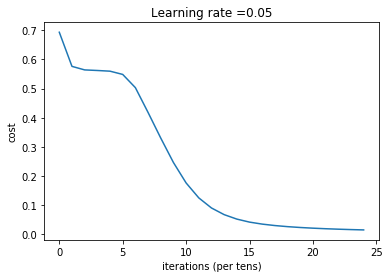

In [69]:
parameters = two_layer_model(X, Y, layers_dims = (n_x, n_h, n_y), learning_rate = 0.05, num_iterations = 2500, print_cost = True)

In [70]:
pred = predict(X, Y, parameters)
print pred

Accuracy: 1.0
[[0. 0. 0. 1.]]


### Predicting a Pulsar Star

In [18]:
# Importing the dataset

dataset = pd.read_csv('C:/Users/A1791729/Desktop/MyProject/Datasets/predicting-a-pulsar-star/pulsar_stars.csv')

In [19]:
X = dataset.iloc[:, 0:8].values
y = dataset.iloc[:, 8].values

In [20]:
# Splitting the dataset into the Training set and Test set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

y_train = np.reshape(y_train,newshape=(len(y_train),1))
y_test = np.reshape(y_test,newshape=(len(y_test),1))

In [21]:
# Feature Scaling

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [22]:
X_train = X_train.T
X_test = X_test.T
y_train = y_train.T
y_test = y_test.T

In [23]:
layers_dims = [8, 10, 10, 1]

Cost after iteration 0: 0.693146
Cost after iteration 100: 0.377549
Cost after iteration 200: 0.331626
Cost after iteration 300: 0.320266
Cost after iteration 400: 0.316700
Cost after iteration 500: 0.315432
Cost after iteration 600: 0.314932
Cost after iteration 700: 0.314695
Cost after iteration 800: 0.314518
Cost after iteration 900: 0.314276
Cost after iteration 1000: 0.313867
Cost after iteration 1100: 0.313302
Cost after iteration 1200: 0.312410
Cost after iteration 1300: 0.310802
Cost after iteration 1400: 0.307503
Cost after iteration 1500: 0.298404
Cost after iteration 1600: 0.244164
Cost after iteration 1700: 0.139392
Cost after iteration 1800: 0.115633
Cost after iteration 1900: 0.104167
Cost after iteration 2000: 0.097632
Cost after iteration 2100: 0.093535
Cost after iteration 2200: 0.090738
Cost after iteration 2300: 0.088707
Cost after iteration 2400: 0.087149


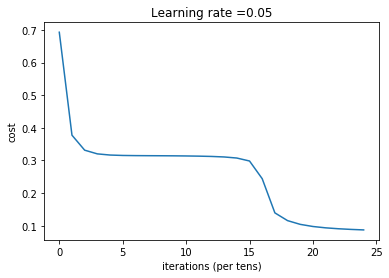

In [26]:
parameters = L_layer_model(X_train, y_train, layers_dims, learning_rate = 0.05, num_iterations = 2500, print_cost = True)

In [59]:
pred_train = predict(X_train, y_train, parameters)

Accuracy: 0.975066350049


In [66]:
pred_test = predict(X_test, y_test, parameters)

Accuracy: 0.981284916201
